In [76]:
#import python lib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Reading & Understanding the Data

Importing the input files

In [77]:
aapl_data = pd.read_csv("AAPL_daily_data.csv")

print(aapl_data)
print(aapl_data.dtypes)

             Date     Open     High      Low    Close  Adj Close     Volume
0      1980-12-12   0.1283   0.1289   0.1283   0.1283     0.0989  469033600
1      1980-12-15   0.1222   0.1222   0.1217   0.1217     0.0938  175884800
2      1980-12-16   0.1133   0.1133   0.1127   0.1127     0.0869  105728000
3      1980-12-17   0.1155   0.1161   0.1155   0.1155     0.0890   86441600
4      1980-12-18   0.1189   0.1194   0.1189   0.1189     0.0916   73449600
...           ...      ...      ...      ...      ...        ...        ...
11035  2024-09-23 227.3400 229.4500 225.8100 226.4700   226.4700   54146000
11036  2024-09-24 228.6500 229.3500 225.7300 227.3700   227.3700   43556100
11037  2024-09-25 224.9300 227.2900 224.0200 226.3700   226.3700   42308700
11038  2024-09-26 227.3000 228.5000 225.4100 227.5200   227.5200   36636700
11039  2024-09-27 228.4600 229.5200 227.3000 227.7900   227.7900   34026000

[11040 rows x 7 columns]
Date          object
Open         float64
High         float64

Inspect Data Frames

In [78]:
# Database dimension
print("Database dimension - aapl_data     :",aapl_data.shape)

#Database size
print("Database size - aapl_data          :",aapl_data.size)

Database dimension - aapl_data     : (11040, 7)
Database size - aapl_data          : 77280


In [79]:
# Database column types
aapl_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11040 entries, 0 to 11039
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11040 non-null  object 
 1   Open       11040 non-null  float64
 2   High       11040 non-null  float64
 3   Low        11040 non-null  float64
 4   Close      11040 non-null  float64
 5   Adj Close  11040 non-null  float64
 6   Volume     11040 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 603.9+ KB


In [80]:
# Data Type Conversion
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])

original_data  = aapl_data.copy()
stock_data = original_data[original_data['Date'] >= '2018-01-01']
stock_data = stock_data.set_index("Date")
stock_data = stock_data.resample('D').ffill()
aapl_data = aapl_data[aapl_data['Date'] >= '2018-04-30']
aapl_data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,1615,1615.0000,1615.0000,1615.0000,1615.0000,1615.0000,1615.0000
mean,2021-07-13 05:29:54.427244544,123.7666,125.1399,122.4869,123.8759,122.0908,100184539.5046
min,2018-04-30 00:00:00,35.9950,36.4300,35.5000,35.5475,33.9899,24048300.0000
25%,2019-12-04 12:00:00,64.5762,65.6600,64.0863,64.9488,63.1082,64534900.0000
50%,2021-07-14 00:00:00,135.2800,136.9900,133.6900,135.2100,133.3434,86693600.0000
75%,2023-02-19 00:00:00,169.1150,170.8150,167.9500,169.0700,167.8169,119044000.0000
max,2024-09-27 00:00:00,236.4800,237.2300,233.0900,234.8200,234.5485,426510000.0000
std,NaN,54.3076,54.8157,53.8150,54.3345,54.7306,54345959.5829


Data Cleaning & Manipulation

Null Value Calculation

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


<Axes: >

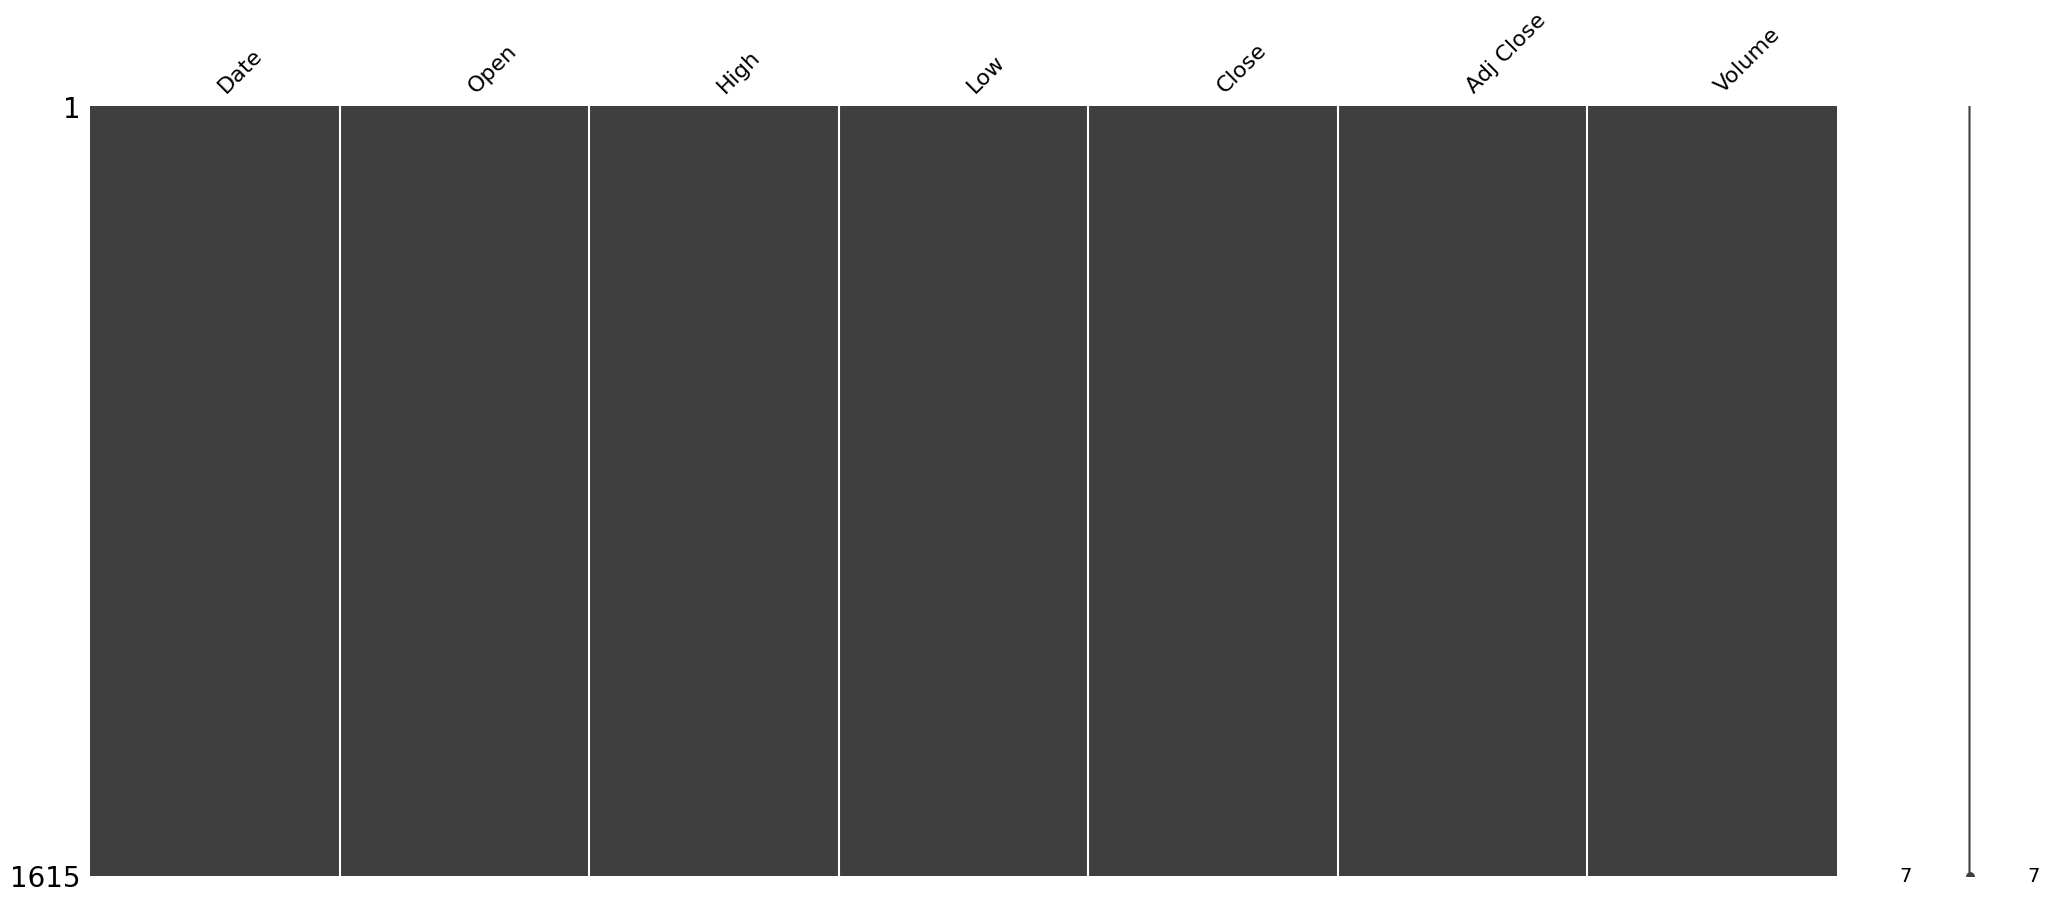

In [81]:
%pip install missingno

import missingno as mn
mn.matrix(aapl_data)

Identifying the Outliers

In [82]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(aapl_data['Adj Close']))

aapl_data_cleaned = aapl_data[z_scores < 3]

print(f"before: {aapl_data.shape}")
print(f"after: {aapl_data_cleaned.shape}")


before: (1615, 7)
after: (1615, 7)


             Open    High     Low  Adj Close  Volume
Open       1.0000  0.9997  0.9997     0.9993 -0.4984
High       0.9997  1.0000  0.9996     0.9996 -0.4921
Low        0.9997  0.9996  1.0000     0.9997 -0.5053
Adj Close  0.9993  0.9996  0.9997     1.0000 -0.5007
Volume    -0.4984 -0.4921 -0.5053    -0.5007  1.0000


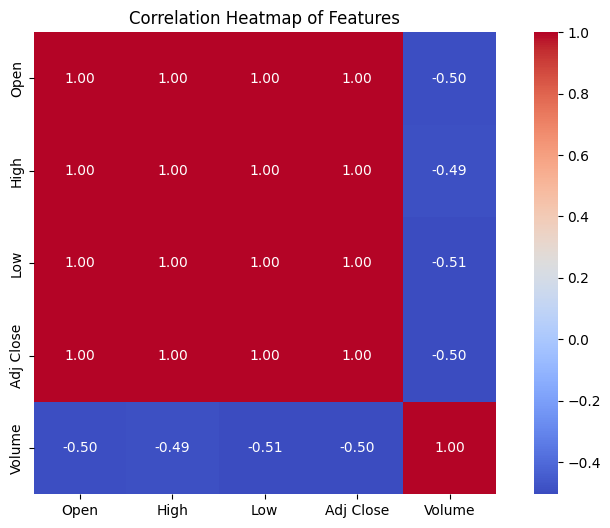

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Select from features
features = aapl_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]

# Calculate the correlation matrix
correlation_matrix = features.corr()

print(correlation_matrix)

# Set drawing style
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Features')
plt.show()


Data Analysis

Numeric Variables Analysis

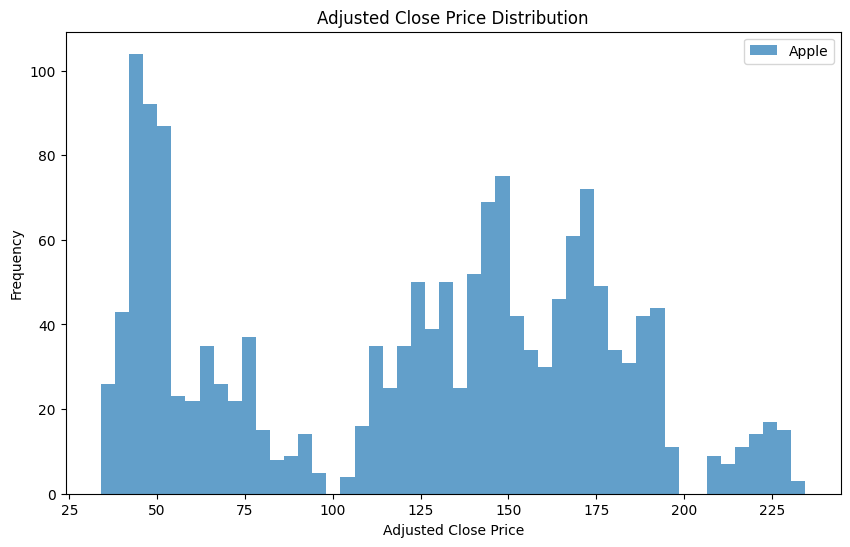

In [84]:
# Plotting the adjusted closing price distribution
# import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(aapl_data['Adj Close'], bins=50, alpha=0.7, label='Apple')
#plt.hist(hon_hai_data_cleaned['Adj Close'], bins=50, alpha=0.7, label='Hon Hai')
#plt.hist(pegatron_data_cleaned['Adj Close'], bins=50, alpha=0.7, label='Pegatron')
plt.title('Adjusted Close Price Distribution')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Plotting Functions

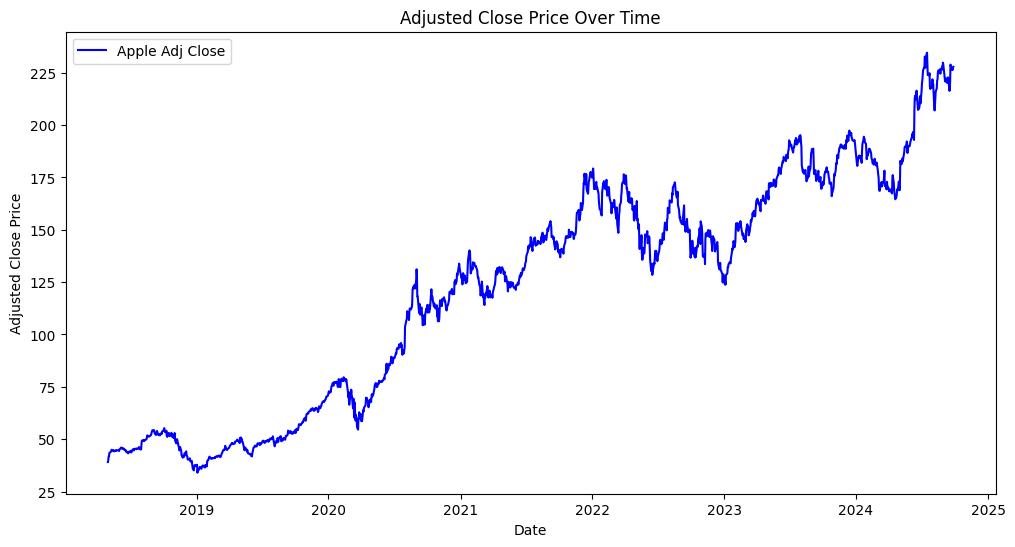

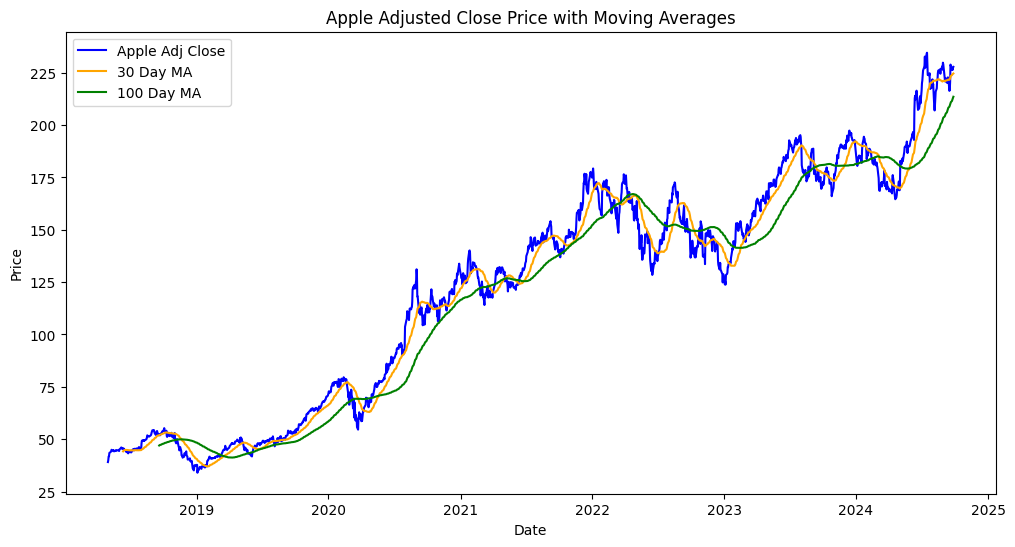

In [85]:
# Plotting the adjusted closing price over time
plt.figure(figsize=(12,6))
plt.plot(aapl_data['Date'], aapl_data['Adj Close'], label='Apple Adj Close', color='blue')
#plt.plot(hon_hai_data_cleaned, hon_hai_data_cleaned['Adj Close'], label='Hon Hai Adj Close', color='red')
#plt.plot(pegatron_data_cleaned, pegatron_data_cleaned['Adj Close'], label='Pegatron Adj Close', color='green')
plt.title('Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Calculate and plot moving average
aapl_data['30_MA'] = aapl_data['Adj Close'].rolling(window=30).mean()
aapl_data['100_MA'] = aapl_data['Adj Close'].rolling(window=100).mean()

plt.figure(figsize=(12,6))
plt.plot(aapl_data['Date'], aapl_data['Adj Close'], label='Apple Adj Close', color='blue')
plt.plot(aapl_data['Date'], aapl_data['30_MA'], label='30 Day MA', color='orange')
plt.plot(aapl_data['Date'], aapl_data['100_MA'], label='100 Day MA', color='green')
plt.title('Apple Adjusted Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Model Building

#### 1. ARIMA

Import necessary libraries

In [86]:
%pip install pmdarima

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Data pre-processing


In [87]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(aapl_data['Adj Close'])

(0.21624603266133777, True)

In [88]:
aapl_data['Adj Close Diff'] = aapl_data['Adj Close'].diff()
aapl_data_diff_cleaned = aapl_data['Adj Close Diff'].dropna()
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(aapl_data_diff_cleaned)

(0.01, False)

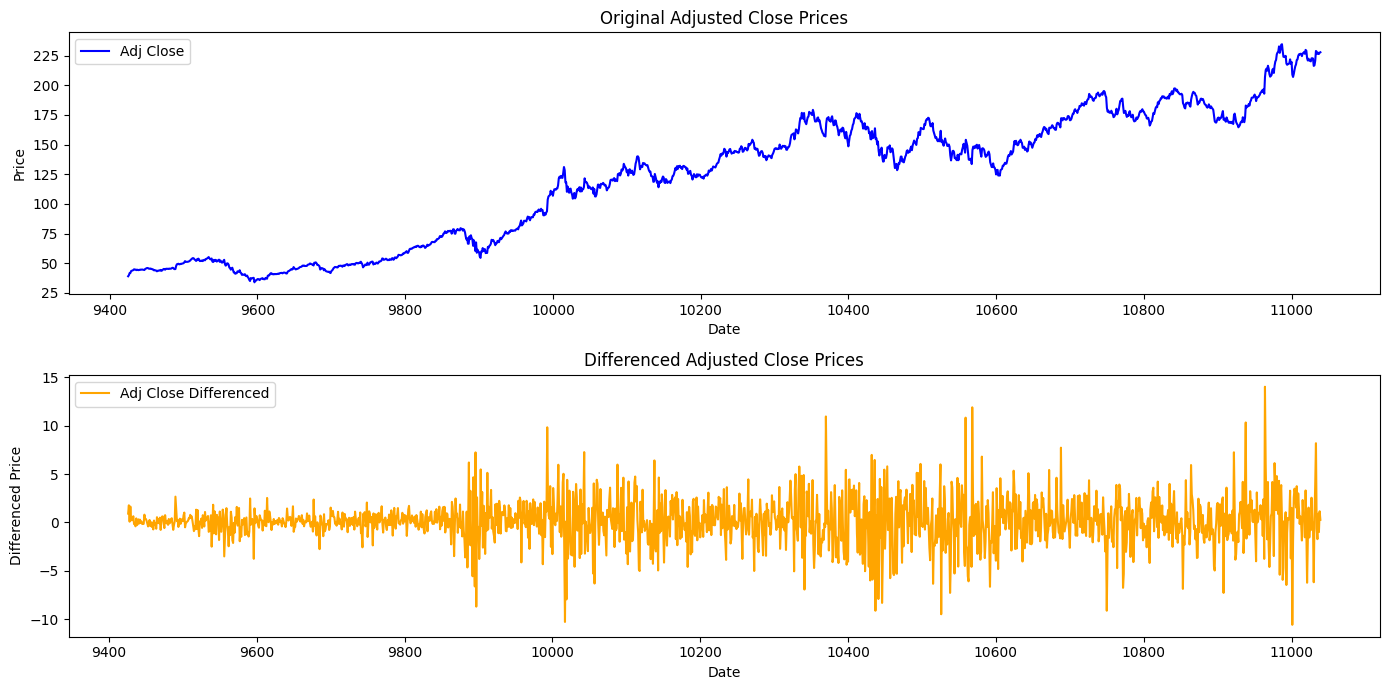

In [89]:
import matplotlib.pyplot as plt

# Plot original adjusted close prices
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(aapl_data['Adj Close'], label='Adj Close', color='blue')
plt.title('Original Adjusted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot differenced prices
plt.subplot(2, 1, 2)
plt.plot(aapl_data_diff_cleaned, label='Adj Close Differenced', color='orange')
plt.title('Differenced Adjusted Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()

plt.tight_layout()
plt.show()




Determine differencing order d using ADF test
ADF test suggests differencing order d = 1

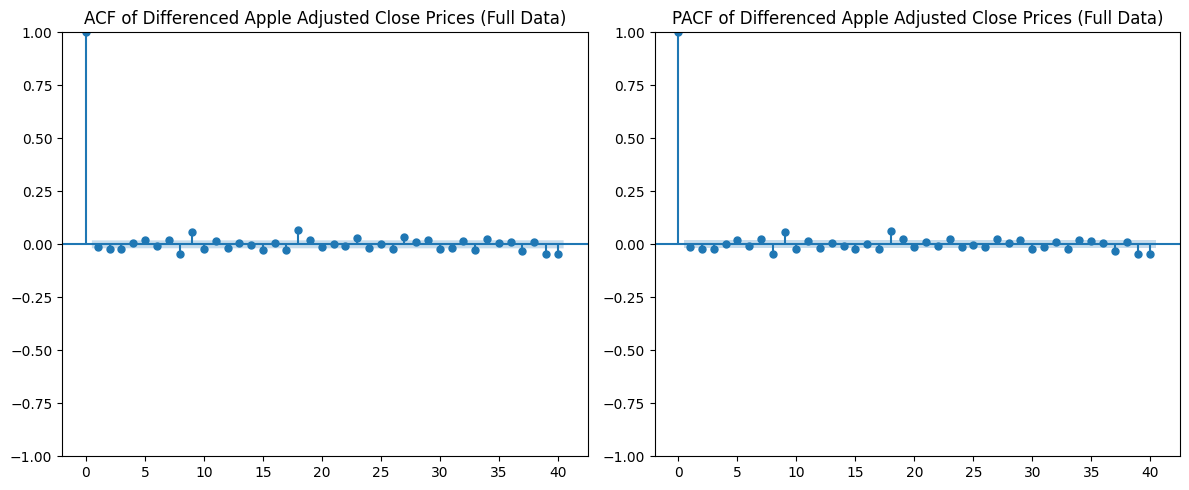

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Perform first-order differencing to make data stationary
aapl_data_diff = original_data['Adj Close'].diff().dropna()

# Plot ACF and PACF for the differenced data
plt.figure(figsize=(12, 5))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(aapl_data_diff, lags=40, ax=plt.gca())
plt.title("ACF of Differenced Apple Adjusted Close Prices (Full Data)")

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(aapl_data_diff, lags=40, ax=plt.gca())
plt.title("PACF of Differenced Apple Adjusted Close Prices (Full Data)")

plt.tight_layout()
plt.show()


In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use the 'Adj Close' column as the time series data and set the date as the index
# adj_close_data = filtered_data.set_index('Date')['Adj Close']
adj_close_data = aapl_data.set_index('Date')['Adj Close']

arima_result = auto_arima(adj_close_data, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=1,
                            start_P=0, seasonal=False,
                            d=None, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# Use the ARIMA model to fit stock prices
# Initially select the lag order p=5, d=1, q=5, which can be adjusted as needed later

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7316.842, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7314.229, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7315.854, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7315.836, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7316.289, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.933 seconds


Make predictions and calculate mean squared error

In [92]:
from sklearn.metrics import mean_squared_error, r2_score
model = ARIMA(adj_close_data, order=(0, 1, 0))
arima_result = model.fit()
print(f'Model AIC: {arima_result.aic}')
# Predict stock prices for the last 60 days
#start = len(adj_close_data) - 91  # Convert start to an integer
start = int(len(adj_close_data) * 0.8)
end = len(adj_close_data) - 1
test_mse = adj_close_data[start:]

arima_pred = arima_result.predict(start=start, end=end, typ='levels')
arima_pred

Model AIC: 7316.289360900288


/Users/tara-r22/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tara-r22/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tara-r22/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
2023-06-16   184.8134
2023-06-20   183.7305
2023-06-21   183.8199
2023-06-22   182.7766
2023-06-23   185.7971
               ...   
2024-09-23   228.2000
2024-09-24   226.4700
2024-09-25   227.3700
2024-09-26   226.3700
2024-09-27   227.5200
Name: predicted_mean, Length: 323, dtype: float64

In [93]:
# Calculate mean square error
mse = mean_squared_error(test_mse, arima_pred)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(test_mse, arima_pred)
print(f'R² Score: {r2}')

arima_mse = mse
arima_rmse = rmse
arima_r2 = r2

Mean Squared Error (MSE): 7.088146303716934
Root Mean Squared Error (RMSE): 2.662357283258003
R² Score: 0.9792759343358819


Visual prediction results

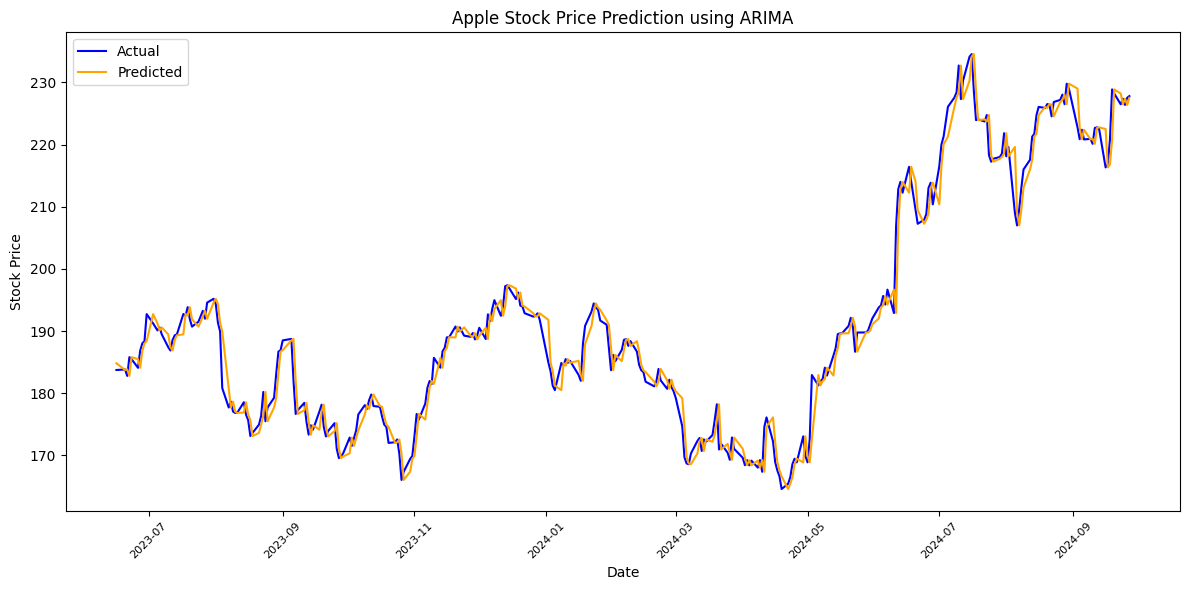

In [94]:
plt.figure(figsize=(12, 6))
plt.plot(adj_close_data.index[start:], adj_close_data[start:], label='Actual', color='blue')
plt.plot(adj_close_data.index[start:], arima_pred, label='Predicted', color='orange')
plt.title('Apple Stock Price Prediction using ARIMA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

#### 2. SVR

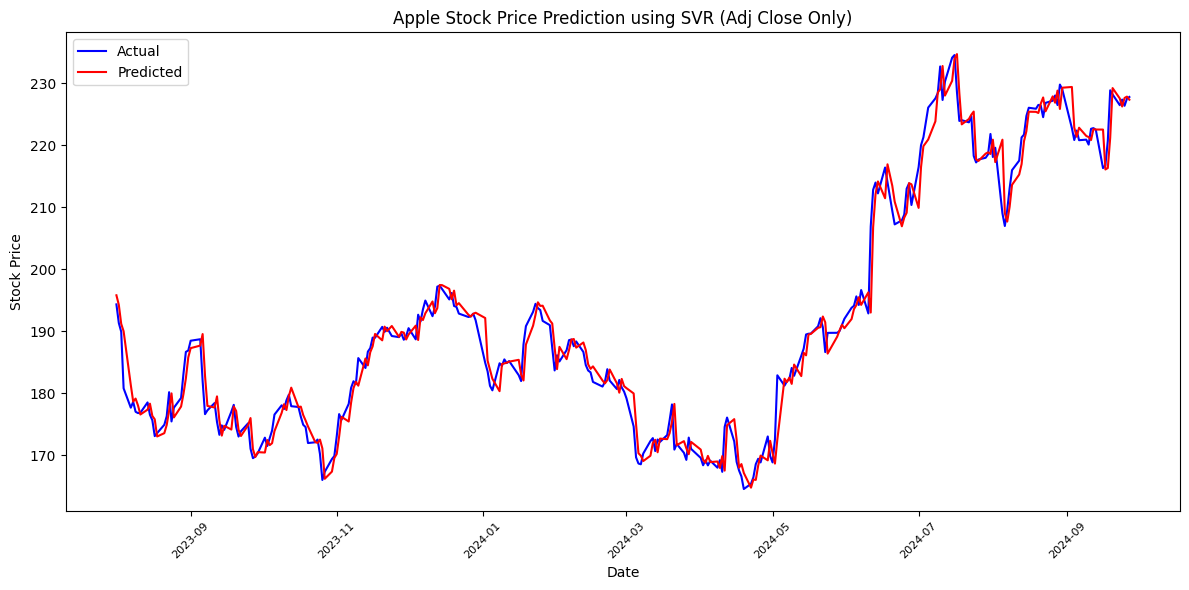

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


# 1. Data loading and preprocessing
# Assume aapl_data is your dataset, which already contains date, opening price, volume and adjusted closing price
# Select only 'Adj Close' as input feature and target variable
adj_close_data = aapl_data['Adj Close'].values.reshape(-1, 1)

# Normalized target value
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_adj_close = scaler_y.fit_transform(adj_close_data)

# Divide the training set and test set
train_size = int(len(scaled_adj_close) * 0.8)

train_adj_close = scaled_adj_close[:train_size]
test_adj_close = scaled_adj_close[train_size:]

# update lookback
lookback = 30

# create dataset
def create_dataset_univariate(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])  # Use only Adj Close
        y.append(data[i+lookback, 0])  # Forecast Adj Close
    return np.array(X), np.array(y)

X_train, y_train = create_dataset_univariate(train_adj_close, lookback)
X_test, y_test = create_dataset_univariate(test_adj_close, lookback)

# Flatten 3D data to 2D data to fit SVR (samples, time steps)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # [samples, time steps]
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# 3. Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10], 
    'epsilon': [0.01, 0.1], 
    'kernel': ['linear', 'rbf']  
}
grid_search = GridSearchCV(SVR(), param_grid, cv=TimeSeriesSplit(n_splits=5))
grid_search.fit(X_train_reshaped, y_train.ravel())
best_model = grid_search.best_estimator_

# 4. Making predictions
y_pred_scaled = best_model.predict(X_test_reshaped)

# Denormalization
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 5. Visualizing prediction results
plt.figure(figsize=(12, 6))
# Use train_size + lookback to calculate the corresponding date
dates = aapl_data['Date'][train_size + lookback:train_size + lookback + len(y_test_actual)]
plt.plot(dates, y_test_actual, label='Actual', color='blue')
plt.plot(dates, y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Apple Stock Price Prediction using SVR (Adj Close Only)')
plt.legend()
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

In [96]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(y_test_actual, y_pred)
print(f'R² Score: {r2}')

svr_mse = mse
svr_rmse = rmse
svr_r2 = r2

Mean Squared Error (MSE): 8.090787353909516
Root Mean Squared Error (RMSE): 2.8444309367445566
R² Score: 0.9784552831636285


#### 3. LSTM

Setup and Model Definition

In [97]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed
def set_all_seeds(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

    def forward(self, x):
        # Explicitly specify initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


Dataset Creation and Training/Evaluation Functions

In [98]:
# Create dataset for multivariate time series
def create_dataset_multivariate(input_data, target_data, lookback):
    X, y = [], []
    for i in range(len(input_data) - lookback):
        X.append(input_data[i:i+lookback, :])
        y.append(target_data[i+lookback, 0])
    return np.array(X), np.array(y)

# Train and evaluate the model
def train_and_evaluate(aapl_data, input_data, target_data, lookback=60, num_epochs=100, batch_size=32):
    # Set random seed
    set_all_seeds(42)

    # Normalize data
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    scaled_input_data = scaler_x.fit_transform(input_data)
    scaled_target_data = scaler_y.fit_transform(target_data)

    # Split data into train and test sets
    train_size = int(len(scaled_input_data) * 0.8)
    train_input_data = scaled_input_data[:train_size]
    train_target_data = scaled_target_data[:train_size]
    test_input_data = scaled_input_data[train_size:]
    test_target_data = scaled_target_data[train_size:]

    # Build dataset
    X_train, y_train = create_dataset_multivariate(train_input_data, train_target_data, lookback)
    X_test, y_test = create_dataset_multivariate(test_input_data, test_target_data, lookback)

    # Convert to PyTorch tensors
    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    X_test = torch.from_numpy(X_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

    # Initialize model
    input_size = X_train.shape[2]
    hidden_size = 64
    output_size = 1
    model = LSTMModel(input_size, hidden_size, output_size).to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Record training loss
    train_losses = []

    # Model training
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for i in range(0, len(X_train), batch_size):
            inputs = X_train[i:i+batch_size]
            targets = y_train[i:i+batch_size]
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

    # Test prediction
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs.squeeze(), y_test)
        predicted_prices = scaler_y.inverse_transform(test_outputs.cpu().numpy().reshape(-1, 1))
        actual_prices = scaler_y.inverse_transform(test_target_data[lookback:])

    print(f'Test Loss: {test_loss.item():.6f}')

    # Calculate errors: MSE, RMSE, R2
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_prices, predicted_prices)
    print(f'MSE: {mse:.6f}, RMSE: {rmse:.6f}, R2: {r2:.6f}')

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(aapl_data['Date'][train_size + lookback:], actual_prices, label='Actual')
    plt.plot(aapl_data['Date'][train_size + lookback:], predicted_prices, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f'Apple Stock Price Prediction Using LSTM (MSE: {mse:.4f})')
    plt.legend()

    # Format date
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
    plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()
    plt.show()

    return model, train_losses, mse, rmse, r2


Running the Prediction and Main Execution

Single feature: Adj Close


Training with single feature (Adj Close):
Epoch [1/100], Loss: 0.006640
Epoch [11/100], Loss: 0.000356
Epoch [21/100], Loss: 0.000311
Epoch [31/100], Loss: 0.000305
Epoch [41/100], Loss: 0.000328
Epoch [51/100], Loss: 0.000387
Epoch [61/100], Loss: 0.000485
Epoch [71/100], Loss: 0.000604
Epoch [81/100], Loss: 0.000284
Epoch [91/100], Loss: 0.000236
Test Loss: 0.000411
MSE: 16.521702, RMSE: 4.064690, R2: 0.958597


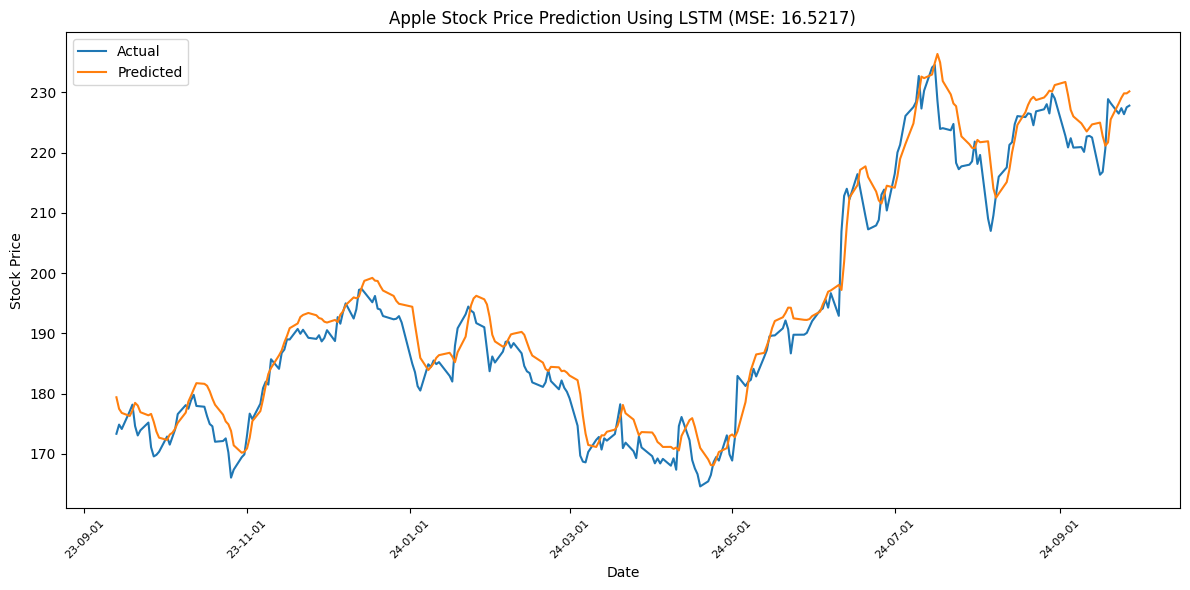

In [99]:
results = {}
def run_single_feature(aapl_data):
    # Single feature: Adj Close
    data_adj_close = aapl_data['Adj Close'].values.reshape(-1, 1)
    print("\nTraining with single feature (Adj Close):")
    model_single, losses_single, mse_single, rmse_single, r2_single = train_and_evaluate(
        aapl_data,
        data_adj_close,
        data_adj_close
    )
    # Store results in the global dictionary
    results['single_feature'] = {
        'model': model_single,
        'losses': losses_single,
        'mse': mse_single,
        'rmse': rmse_single,
        'r2': r2_single
    }

# Run the single feature training
run_single_feature(aapl_data)

Model Performance Comparison

In [100]:
pd.set_option('display.float_format', '{:.4f}'.format)  # set float


# Create a results DataFrame
results_table = pd.DataFrame({
    'Algorithm': ['ARIMA', 'SVR', 'LSTM'],
    'MSE': [
        arima_mse,
        svr_mse,
        results['single_feature']['mse']
    ],
    'RMSE': [
        arima_rmse,
        svr_rmse,
        results['single_feature']['rmse']
    ],
    'R²': [
        arima_r2,
        svr_r2,
        results['single_feature']['r2']
    ]
})

results_table


,Algorithm,MSE,RMSE,R²
0,ARIMA,7.0881,2.6624,0.9793
1,SVR,8.0908,2.8444,0.9785
2,LSTM,16.5217,4.0647,0.9586


In [101]:
financial_data = pd.read_csv("filtered_quarterly_data.csv")
financial_data = financial_data.dropna(axis=1)
financial_data["Date"] = pd.to_datetime(financial_data["fiscalDateEnding"])
financial_data["fiscalDateEnding"] = pd.to_datetime(financial_data["fiscalDateEnding"])
financial_data["reportReleaseDate"] = financial_data["fiscalDateEnding"] + pd.Timedelta(days=30)


balance_data = pd.read_csv("filtered_bal_quarterly.csv")
balance_data = balance_data.dropna(axis=1)
balance_data["Date"] = pd.to_datetime(balance_data["fiscalDateEnding"])
balance_data["fiscalDateEnding"] = pd.to_datetime(balance_data["fiscalDateEnding"])
balance_data["reportReleaseDate"] = balance_data["fiscalDateEnding"] + pd.Timedelta(days=30)

financial_data = financial_data.set_index("reportReleaseDate")
balance_data = balance_data.set_index("reportReleaseDate")

#Calculation of financial ratios
financial_data["Net Profit Margin"] = financial_data["netIncome"] / financial_data["totalRevenue"]
financial_data["ROA"] = financial_data["netIncome"] / balance_data["totalAssets"]
financial_data["EBIT Margin"] = financial_data["ebit"] / financial_data["totalRevenue"]

#Calculate Price/Earnings Ratio (P/E Ratio) and Price/Book Ratio (P/B Ratio)
financial_data["EPS"] = financial_data["netIncome"] / balance_data["commonStockSharesOutstanding"]
financial_data["P/E Ratio"] = stock_data["Close"] / financial_data["EPS"]
financial_data["Book Value per Share"] = balance_data["totalAssets"] / balance_data["commonStockSharesOutstanding"]
financial_data["P/B Ratio"] = stock_data["Close"] / financial_data["Book Value per Share"]
financial_data["Operating Margin"] = financial_data["operatingIncome"] / financial_data["totalRevenue"]
financial_data["Gross Margin"] = financial_data["grossProfit"] / financial_data["totalRevenue"]
financial_data["R&D to Revenue"] = financial_data["researchAndDevelopment"] / financial_data["totalRevenue"]
financial_data["Cost Efficiency"] = financial_data["grossProfit"] / financial_data["costOfRevenue"]
financial_data["Operating Leverage"] = financial_data["operatingIncome"] / financial_data["ebit"]

feature_data = financial_data[["Net Profit Margin", "ROA", "EBIT Margin", "P/E Ratio", "P/B Ratio", 
                              "Operating Margin", "Gross Margin", "R&D to Revenue", 
                              "Cost Efficiency", "Operating Leverage"]]
print(feature_data.head())
#Consolidated stock price data and financial data
merged_data = stock_data.merge(feature_data, how="left", left_index=True, right_index=True)

#Fill in financial numbers forward
merged_data = merged_data.fillna(method="ffill")
#merged_data = merged_data.drop(columns=["fiscalDateEnding", "reportedCurrency"])

merged_data = merged_data[merged_data.index >= '2018-04-30']
merged_data.to_csv("apple_stock_with_financials.csv")

                   Net Profit Margin    ROA  EBIT Margin  P/E Ratio  \
reportReleaseDate                                                     
2024-10-27                    0.1552 0.0404       0.3117        NaN   
2024-07-30                    0.2500 0.0647       0.2956   155.2886   
2024-04-30                    0.2604 0.0701       0.3074   110.5292   
2024-01-30                    0.2836 0.0959       0.3376    85.7159   
2023-10-30                    0.2594 0.0651       0.3164   115.3520   

                   P/B Ratio  Operating Margin  Gross Margin  R&D to Revenue  \
reportReleaseDate                                                              
2024-10-27               NaN            0.3117        0.4622          0.0818   
2024-07-30           10.0438            0.2956        0.4626          0.0933   
2024-04-30            7.7427            0.3074        0.4658          0.0871   
2024-01-30            8.2236            0.3376        0.4587          0.0644   
2023-10-30            

/var/folders/8m/kzty2hjd00ld6b1dl3s2v6r80000gp/T/ipykernel_68729/3895595691.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = merged_data.fillna(method="ffill")


In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

#Calculate the correlation matrix
correlation_matrix = merged_data.corr()

#Get correlation with Close price
close_correlations = correlation_matrix['Adj Close'].sort_values(ascending=False)

#Print formatted correlation results
print("\nCorrelations with Stock Close Price:")
print("=====================================")
for feature, correlation in close_correlations.items():
        print(f"{feature:<25}: {correlation:>7.3f}")

#strong correlation (|correlation| > 0.5)
print("\nStrong Correlations (|correlation| > 0.5):")
print("=========================================")
strong_correlations = close_correlations[(abs(close_correlations) > 0.5) & (abs(close_correlations) < 0.999)]
for feature, correlation in strong_correlations.items():
        print(f"{feature:<25}: {correlation:>7.3f}")


Correlations with Stock Close Price:
Adj Close                :   1.000
Close                    :   1.000
Low                      :   1.000
High                     :   1.000
Open                     :   0.999
P/B Ratio                :   0.938
Gross Margin             :   0.916
P/E Ratio                :   0.862
Operating Leverage       :   0.843
Cost Efficiency          :   0.822
ROA                      :   0.696
Operating Margin         :   0.680
Net Profit Margin        :   0.640
EBIT Margin              :   0.585
R&D to Revenue           :   0.476
Volume                   :  -0.472

Strong Correlations (|correlation| > 0.5):
P/B Ratio                :   0.938
Gross Margin             :   0.916
P/E Ratio                :   0.862
Operating Leverage       :   0.843
Cost Efficiency          :   0.822
ROA                      :   0.696
Operating Margin         :   0.680
Net Profit Margin        :   0.640
EBIT Margin              :   0.585


Feature importance: Adj Close            6.4231
P/E Ratio            2.1752
P/B Ratio            2.1977
ROA                  2.2062
Gross Margin         2.2624
Operating Margin     2.2226
Net Profit Margin    2.2397
Operating Leverage   2.2006
EBIT Margin          2.2056
Cost Efficiency      2.2659
R&D to Revenue       2.2424
dtype: float64
Selected features: Index(['Adj Close', 'Cost Efficiency', 'Gross Margin', 'R&D to Revenue',
       'Net Profit Margin', 'Operating Margin', 'ROA'],
      dtype='object')
Best parameters: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}
result:
MAE: $1.74
RMSE: $2.49
R²: 0.9827


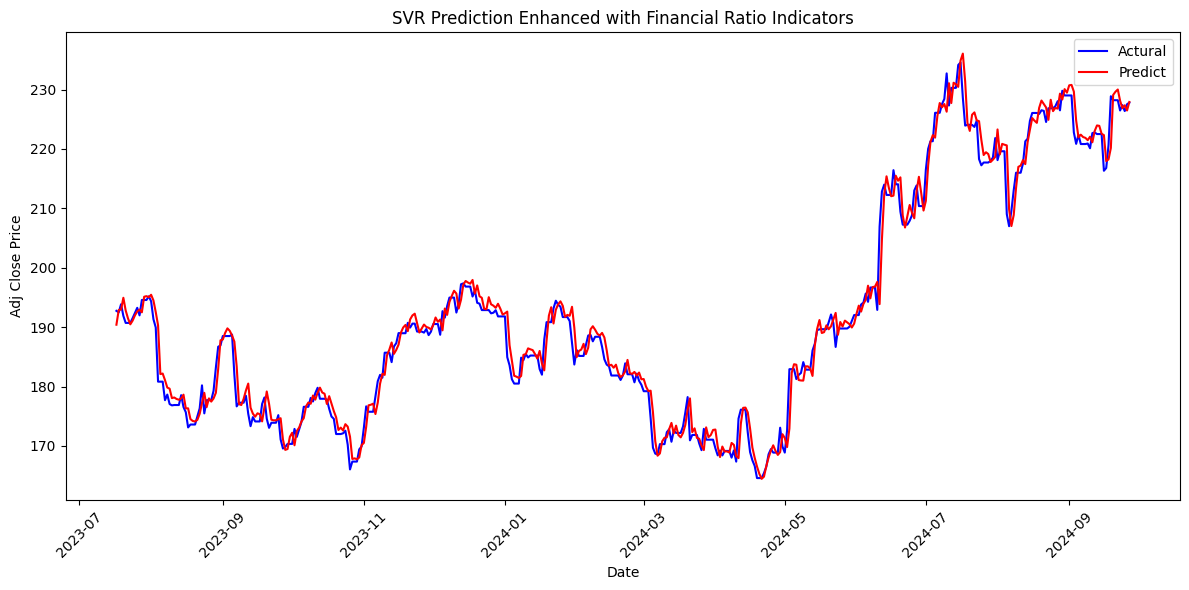

In [104]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_regression

# 1. Data Preparation - Combining Price Data and Financial Characteristics
# Using previously processed merged_data (containing price data and financial indicators)

# Select the features to be used

financial_features = ["P/E Ratio", "P/B Ratio", "ROA", "Gross Margin", "Operating Margin", 
                      "Net Profit Margin", "Operating Leverage", "EBIT Margin", "Cost Efficiency", "R&D to Revenue"]  # 财务指标
price_features = ['Adj Close']
features = price_features + financial_features

merged_data = merged_data.dropna()
X = merged_data[features].values
y = merged_data['Adj Close'].values.reshape(-1, 1)  # 目标变量

# 2. Feature standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

#Importance of computational features
mi_scores = mutual_info_regression(X_scaled, y_scaled.ravel())
feature_importance = pd.Series(mi_scores, index=features)
selected_features = feature_importance.nlargest(7).index  # Select the top 7 most important features
X_scaled = merged_data[selected_features].values
print(f"Feature importance: {feature_importance}")
print(f"Selected features: {selected_features}")
# # RFE
# rfe = RFE(SVR(kernel='linear'), n_features_to_select=7) 
# X_scaled = rfe.fit_transform(X_scaled, y_scaled.ravel())

# print(f"Selected features: {np.array(features)[rfe.support_]}")
# print(f"Feature rankings: {rfe.ranking_}")

train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]

# 4. Build a dataset containing time-series features
lookback = 30 

def create_dataset_multivariate(X, y, lookback):
    X_out, y_out = [], []
    for i in range(lookback, len(X)):
        # Contains all the features of the past lookback days
        features_sequence = X[i-lookback:i]
        X_out.append(features_sequence)
        y_out.append(y[i])
    return np.array(X_out), np.array(y_out)

X_train_seq, y_train_seq = create_dataset_multivariate(X_train, y_train, lookback)
X_test_seq, y_test_seq = create_dataset_multivariate(X_test, y_test, lookback)

# Reshape data to fit SVR (number of samples, number of features × time step)
X_train_reshaped = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_test_reshaped = X_test_seq.reshape(X_test_seq.shape[0], -1)

# 5. hyperparameter tuning
param_grid = {
    'C': [0.1], 
    'epsilon': [0.01], 
    'kernel': ['linear']  
}

grid_search = GridSearchCV(SVR(), param_grid, cv=TimeSeriesSplit(n_splits=3))
grid_search.fit(X_train_reshaped, y_train_seq.ravel())
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

y_pred_scaled = best_model.predict(X_test_reshaped)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

mae = np.mean(np.abs(y_test_actual - y_pred))
rmse = np.sqrt(np.mean((y_test_actual - y_pred)**2))
r2 = r2_score(y_test_actual, y_pred)

print(f"result:")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
dates = merged_data.index[train_size+lookback:train_size+lookback+len(y_test_actual)]
plt.plot(dates, y_test_actual, label='Actural', color='blue')
plt.plot(dates, y_pred, label='Predict', color='red')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('SVR Prediction Enhanced with Financial Ratio Indicators')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [105]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(y_test_actual, y_pred)
print(f'R² Score: {r2}')

svr_mse = mse
svr_rmse = rmse
svr_r2 = r2

Mean Squared Error (MSE): 6.215348633790035
Root Mean Squared Error (RMSE): 2.4930600942997816
R² Score: 0.9826772504038692


In [106]:
%pip install torch

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed
def set_all_seeds(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

    def forward(self, x):
        # Explicitly specify initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [109]:
# Create dataset for multivariate time series
def create_dataset_multivariate(input_data, target_data, lookback):
    X, y = [], []
    for i in range(len(input_data) - lookback):
        X.append(input_data[i:i+lookback, :])
        y.append(target_data[i+lookback, 0])
    return np.array(X), np.array(y)

# Train and evaluate the model
def train_and_evaluate(aapl_data, input_data, target_data, lookback=60, num_epochs=100, batch_size=32):
    # Set random seed
    set_all_seeds(42)

    # Normalize data
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    scaled_input_data = scaler_x.fit_transform(input_data)
    scaled_target_data = scaler_y.fit_transform(target_data)

    # Split data into train and test sets
    train_size = int(len(scaled_input_data) * 0.8)
    train_input_data = scaled_input_data[:train_size]
    train_target_data = scaled_target_data[:train_size]
    test_input_data = scaled_input_data[train_size:]
    test_target_data = scaled_target_data[train_size:]

    # Build dataset
    X_train, y_train = create_dataset_multivariate(train_input_data, train_target_data, lookback)
    X_test, y_test = create_dataset_multivariate(test_input_data, test_target_data, lookback)

    # Convert to PyTorch tensors
    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    X_test = torch.from_numpy(X_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

    # Initialize model
    input_size = X_train.shape[2]
    hidden_size = 64
    output_size = 1
    model = LSTMModel(input_size, hidden_size, output_size).to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Record training loss
    train_losses = []

    # Model training
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for i in range(0, len(X_train), batch_size):
            inputs = X_train[i:i+batch_size]
            targets = y_train[i:i+batch_size]
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

    # Test prediction
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs.squeeze(), y_test)
        predicted_prices = scaler_y.inverse_transform(test_outputs.cpu().numpy().reshape(-1, 1))
        actual_prices = scaler_y.inverse_transform(test_target_data[lookback:])

    print(f'Test Loss: {test_loss.item():.6f}')

    # Calculate errors: MSE, RMSE, R2
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_prices, predicted_prices)
    print(f'MSE: {mse:.6f}, RMSE: {rmse:.6f}, R2: {r2:.6f}')

    # Visualization
    plt.figure(figsize=(12, 6))
    dates = merged_data.index[train_size+lookback:train_size+lookback+len(y_test_actual)]
    plt.plot(dates, actual_prices, label='Actual')
    plt.plot(dates, predicted_prices, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('LSTM Prediction Enhanced with Financial Ratio Indicators')
    plt.legend()

    return model, train_losses, mse, rmse, r2



Training with multiple features:
Epoch [1/100], Loss: 0.012753
Epoch [11/100], Loss: 0.003885
Epoch [21/100], Loss: 0.001627
Epoch [31/100], Loss: 0.000886
Epoch [41/100], Loss: 0.000439
Epoch [51/100], Loss: 0.000383
Epoch [61/100], Loss: 0.000217
Epoch [71/100], Loss: 0.000295
Epoch [81/100], Loss: 0.000429
Epoch [91/100], Loss: 0.000332
Test Loss: 0.003272
MSE: 131.602143, RMSE: 11.471798, R2: 0.653270


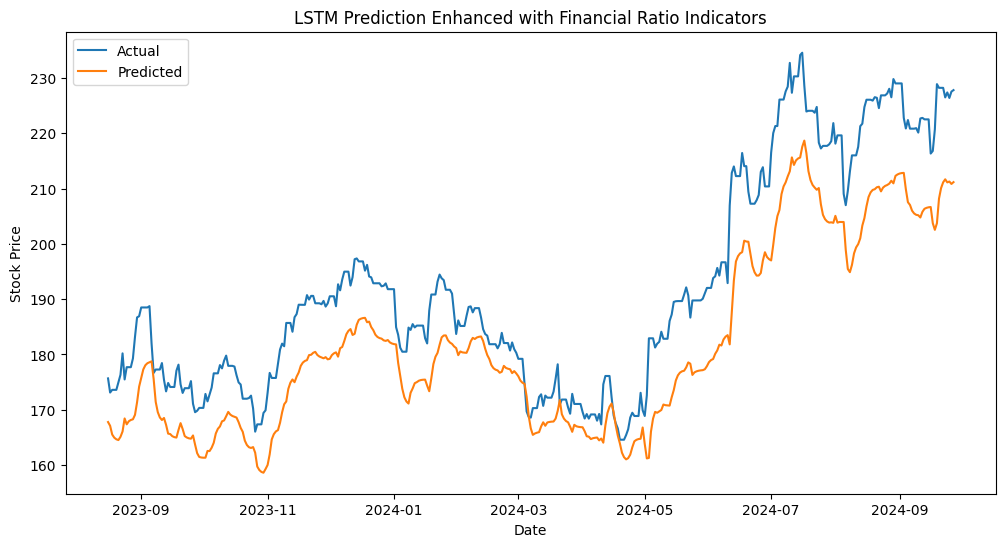

In [ ]:
def run_base_multi_feature(aapl_data):
    data_adj_close = aapl_data['Adj Close'].values.reshape(-1, 1)
    # Multiple features: Open, Volume, Adj Close
    data_multi = np.hstack((
        aapl_data['Adj Close'].values.reshape(-1, 1),
        aapl_data['Net Profit Margin'].values.reshape(-1, 1),
        aapl_data['ROA'].values.reshape(-1, 1),
        aapl_data['Operating Margin'].values.reshape(-1, 1),
        aapl_data['Gross Margin'].values.reshape(-1, 1),
        aapl_data['R&D to Revenue'].values.reshape(-1, 1),
        aapl_data['Cost Efficiency'].values.reshape(-1, 1),
    ))
    print("\nTraining with multiple features:")
    model_multi, losses_multi, mse_multi, rmse_multi, r2_multi = train_and_evaluate(
        aapl_data,
        data_multi,
        data_adj_close
    )

# Run the multi feature training
run_base_multi_feature(merged_data)


Training with multiple features:
Epoch [1/100], Loss: 0.010253
Epoch [11/100], Loss: 0.003090
Epoch [21/100], Loss: 0.001330
Epoch [31/100], Loss: 0.000531
Epoch [41/100], Loss: 0.000844
Epoch [51/100], Loss: 0.000553
Epoch [61/100], Loss: 0.000895
Epoch [71/100], Loss: 0.000355
Epoch [81/100], Loss: 0.000720
Epoch [91/100], Loss: 0.000396
Test Loss: 0.000472
MSE: 18.985212, RMSE: 4.357202, R2: 0.949980


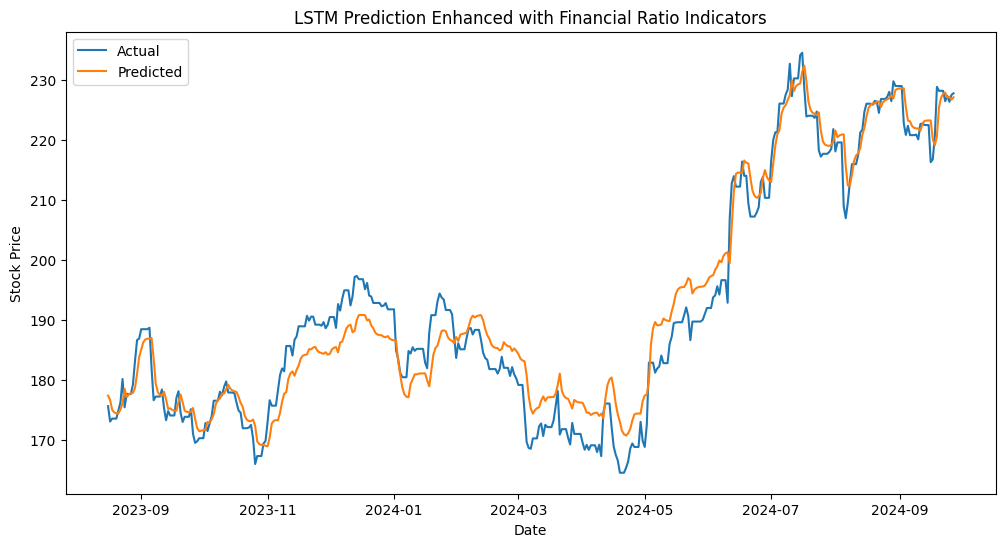

In [113]:
def run_multi_feature(aapl_data):
    data_adj_close = aapl_data['Adj Close'].values.reshape(-1, 1)
    data_multi = np.hstack((
        aapl_data['Adj Close'].values.reshape(-1, 1),
        aapl_data['Net Profit Margin'].values.reshape(-1, 1),
        aapl_data['ROA'].values.reshape(-1, 1),
        aapl_data['P/E Ratio'].values.reshape(-1, 1),
        aapl_data['Operating Margin'].values.reshape(-1, 1),
        aapl_data['Gross Margin'].values.reshape(-1, 1),
        aapl_data['R&D to Revenue'].values.reshape(-1, 1),
        aapl_data['Cost Efficiency'].values.reshape(-1, 1),
        aapl_data['Operating Leverage'].values.reshape(-1, 1)
    ))
    print("\nTraining with multiple features:")
    model_multi, losses_multi, mse_multi, rmse_multi, r2_multi = train_and_evaluate(
        aapl_data,
        data_multi,
        data_adj_close
    )

# Run the multi feature training
run_multi_feature(merged_data)

In [112]:
improvement = (131.602143 - 18.985212) / 131.602143 * 100
print(f"\nIncremental Analysis Results:")
print(f"Base MSE: 131.602143 | Full MSE: 18.985212")
print(f"MSE Improvement: {improvement:.2f}%")


Incremental Analysis Results:
Base MSE: 131.602143 | Full MSE: 18.985212
MSE Improvement: 85.57%
